## Preprocess
### Import

In [378]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
from dgl import save_graphs, load_graphs
import h5py
from XMLHandler import XMLHandler

### Data Loading

In [185]:
photon_file = h5py.File('../data/dataset_1_photons_1.hdf5', 'r')
xml = XMLHandler('photon', filename='../data/binning_dataset_1_photons.xml')

### Data Process

In [391]:
def get_orig_coord(bin_no, xml):
    for layer in range(len(xml.bin_edges)):
        if bin_no >= xml.bin_edges[layer]:
            continue
        else:
            layer = layer-1
            break
    bin_no = bin_no - xml.bin_edges[layer]
    r_bin = int(bin_no / xml.a_bins[layer])
    alpha_bin = bin_no % xml.a_bins[layer]
    return layer, r_bin, alpha_bin

def get_coord(bin_no, xml):
    layer, r_bin, alpha_bin = get_orig_coord(bin_no, xml)
    r = xml.r_midvalue[layer][r_bin]
    alpha = xml.alphaListPerLayer[layer][r_bin][alpha_bin]
    eta = r * math.sin(alpha)
    phi = r * math.cos(alpha)
    z = layer
    return eta, phi, z

In [392]:
def generate_graph_from_incident(incident_data):
    bin_num = len(incident_data)

    edges_start = torch.arange(bin_num).repeat(bin_num)
    edges_end = torch.repeat_interleave(torch.arange(bin_num),bin_num)
    g = dgl.graph((edges_start, edges_end))

    g.ndata['x'] = torch.empty(g.num_nodes(), 4)

    for bin_no in range(bin_num):
        eta, phi, z = get_coord(bin_no, xml)
        energy = incident_data[bin_no]
        g.ndata['x'][bin_no] = torch.tensor([eta, phi, z, energy])

    return g

def generate_knn_graph_from_incident(incident_data, k):
    bin_num = len(incident_data)

    x = torch.empty(bin_num, 3)
    energy = torch.empty(bin_num)

    for bin_no in range(bin_num):
        eta, phi, z = get_coord(bin_no, xml)
        energy[bin_no] = incident_data[bin_no]
        x[bin_no] = torch.tensor([eta, phi, z])

    knn_g = dgl.knn_graph(x, k, algorithm='bruteforce-blas', dist='euclidean')

    energy = energy.view(bin_num,1)
    knn_g.ndata['x'] = torch.cat((x, energy), -1)

    return knn_g

In [393]:
shower_data = photon_file["showers"][:]
energy_data = photon_file["incident_energies"][:]

graph_list = []
knn_graph_list = []

# for incident_no in range(len(data)):
for incident_no in range(10000):
    g = generate_graph_from_incident(shower_data[incident_no])
    graph_list.append(g)
    knn_g = generate_knn_graph_from_incident(shower_data[incident_no], 5)
    knn_graph_list.append(knn_g)

### Saving Data

In [394]:
graph_path = "../data/graph.bin"
knn_graph_path = "../data/knn_graph.bin"
save_graphs(graph_path, graph_list)
save_graphs(knn_graph_path, knn_graph_list)

### Loading Data

In [ ]:
graph_path = "../data/graph.bin"
knn_graph_path = "../data/knn_graph.bin"
graph_list = load_graphs(graph_path)
knn_graph_list = load_graphs(knn_graph_path)

## GCNLayer and GCN

In [188]:
# class GCNLayer(nn.Module):
#
#     def __init__(self, c_in, c_out):
#         super().__init__()
#         self.projection = nn.Linear(c_in, c_out)
#
#     def forward(self, node_feats, adj_matrix):
#         num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
#         node_feats = self.projection(node_feats)
#         node_feats = torch.bmm(adj_matrix, node_feats)
#         node_feats = node_feats / num_neighbours
#         return node_feats
#
# test_graph = graph_list[0]
# node_feats = test_graph.ndata['x'].view(1, 368, 4)
# adj_matrix = torch.ones(1, 368, 368)
# layer = GCNLayer(c_in=4, c_out=4)
# layer.projection.weight.data = torch.Tensor([[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]])
# layer.projection.bias.data = torch.Tensor([0., 0., 0., 0.])
#
# with torch.no_grad():
#     out_feats = layer(node_feats, adj_matrix)
#
# print("input: ", node_feats)
# print("output: ", out_feats)

In [ ]:
class GCNLayer(nn.Module):

    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv = GraphConv(in_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv(g, in_feat)
        h = F.relu(h)
        return h

In [326]:
class GCN(nn.Module):

    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, 1)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')[0]

### Test of 1-layer GCN with complete graph

In [327]:
# Pass a graph through a GCNLayer
test_graph = graph_list[0]
node_feats = test_graph.ndata['x']
model = GCNLayer(in_feats=4, h_feats=4)

with torch.no_grad():
    out_feats = model(test_graph, node_feats)

print("input: ", node_feats)
print("output: ", out_feats)

input:  tensor([[   0.0000,    2.5000,    0.0000,  300.0140],
        [   0.0000,    7.5000,    0.0000,   44.5615],
        [   0.0000,   20.0000,    0.0000,    0.0000],
        ...,
        [   0.0000,  300.0000,   12.0000,    0.0000],
        [   0.0000,  700.0000,   12.0000,    0.0000],
        [   0.0000, 1500.0000,   12.0000,    0.0000]])
output:  tensor([0.])


### Test of 1-layer GCN with k-nn graph

In [328]:
# Pass a k-nn graph through a GCNLayer
test_graph = knn_graph_list[0]
node_feats = test_graph.ndata['x']
model = GCNLayer(in_feats=4, h_feats=4)

with torch.no_grad():
    out_feats = model(test_graph, node_feats)

print("input: ", node_feats)
print("output: ", out_feats)

input:  tensor([[   0.0000,    2.5000,    0.0000,  300.0140],
        [   0.0000,    7.5000,    0.0000,   44.5615],
        [   0.0000,   20.0000,    0.0000,    0.0000],
        ...,
        [   0.0000,  300.0000,   12.0000,    0.0000],
        [   0.0000,  700.0000,   12.0000,    0.0000],
        [   0.0000, 1500.0000,   12.0000,    0.0000]])
output:  tensor([-2.0683])


## Training
### Test Training 1

graph type: complete graph
number of incidents: 1
epochs: 1000
opt: Adam
loss function: abs
dim of hidden features: 16

In [338]:
def train(g, model, label):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    inputs = g.ndata['x']

    for epoch in range(1000):
        pred = model(g, inputs)
        loss = abs(pred - label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print('In epoch {}, loss: {:.3f}'.format(epoch, loss[0]))

In [339]:
model = GCN(in_feats=4, h_feats=16)
test_graph = graph_list[0]
label = torch.Tensor(energy_data[0])
train(test_graph, model, label)

/Users/kasphysm/miniforge3/envs/pytorch-nightly/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 16376.557
In epoch 100, loss: 15869.417
In epoch 200, loss: 14155.543
In epoch 300, loss: 11141.400
In epoch 400, loss: 6865.557
In epoch 500, loss: 1376.812
In epoch 600, loss: 7.631
In epoch 700, loss: 4.997
In epoch 800, loss: 1.326
In epoch 900, loss: 8.533


### Test Training 2

graph type: complete graph
number of incidents: 100
epochs: 1000
opt: Adam
loss function: abs
dim of hidden features: 4

In [368]:
loss_list = []

def batch_train(dataset, model, labels):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1000):
        for i in range(len(dataset[:100])):
            g = dataset[i]
            inputs = g.ndata['x']
            pred = model(g, inputs)
            loss = abs(pred - labels[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            print('In epoch {}, loss: {:.3f}'.format(epoch, loss[0]))
            loss_list.append(float(loss[0]))

In [369]:
model = GCN(in_feats=4, h_feats=4)
labels = torch.Tensor(energy_data)
batch_train(graph_list, model, labels)

/Users/kasphysm/miniforge3/envs/pytorch-nightly/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 4095.010
In epoch 5, loss: 3893.058
In epoch 10, loss: 2548.695
In epoch 15, loss: 884.875
In epoch 20, loss: 1007.257
In epoch 25, loss: 2913.653
In epoch 30, loss: 4717.004
In epoch 35, loss: 4657.673
In epoch 40, loss: 3251.000
In epoch 45, loss: 1972.594
In epoch 50, loss: 832.509
In epoch 55, loss: 14.742
In epoch 60, loss: 20.126
In epoch 65, loss: 20.614
In epoch 70, loss: 15.334
In epoch 75, loss: 15.834
In epoch 80, loss: 15.761
In epoch 85, loss: 16.208
In epoch 90, loss: 16.511
In epoch 95, loss: 16.958
In epoch 100, loss: 17.260
In epoch 105, loss: 17.659
In epoch 110, loss: 18.010
In epoch 115, loss: 18.385
In epoch 120, loss: 18.752
In epoch 125, loss: 19.124
In epoch 130, loss: 19.500
In epoch 135, loss: 19.834
In epoch 140, loss: 20.215
In epoch 145, loss: 14.872
In epoch 150, loss: 15.342
In epoch 155, loss: 15.250
In epoch 160, loss: 15.616
In epoch 165, loss: 15.991
In epoch 170, loss: 16.342
In epoch 175, loss: 16.707
In epoch 180, loss: 17.084
In 

In [373]:
print("min loss: {:.3f}".format(min(loss_list)))

min loss: 11.084


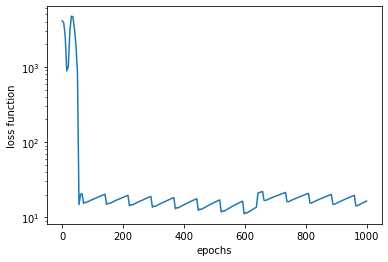

In [372]:
w = np.linspace(0, 1000, 200)
loss_array = np.array(loss_list)
plt.axes(yscale = "log")
plt.plot(w, loss_array, label='Loss')
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.show()

### Test Training 3

graph type: k-nn graph
number of incidents: 1000
epochs: 100
opt: Adam
loss function: abs
dim of hidden features: 16

In [395]:
loss_list = []

def batch_train(dataset, model, labels):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(100):
        for i in range(len(dataset[:1000])):
            g = dataset[i]
            inputs = g.ndata['x']
            pred = model(g, inputs)
            loss = abs(pred - labels[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            print('In epoch {}, loss: {:.3f}'.format(epoch, loss[0]))
            loss_list.append(float(loss[0]))

In [396]:
model = GCN(in_feats=4, h_feats=16)
labels = torch.Tensor(energy_data)
batch_train(knn_graph_list, model, labels)

/Users/kasphysm/miniforge3/envs/pytorch-nightly/lib/python3.8/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 7797.876
In epoch 5, loss: 9723.191
In epoch 10, loss: 9680.385
In epoch 15, loss: 9682.990
In epoch 20, loss: 9676.445
In epoch 25, loss: 9696.044
In epoch 30, loss: 9670.901
In epoch 35, loss: 9673.746
In epoch 40, loss: 9702.613
In epoch 45, loss: 9671.406
In epoch 50, loss: 9695.039
In epoch 55, loss: 9679.957
In epoch 60, loss: 9673.216
In epoch 65, loss: 9715.562
In epoch 70, loss: 9683.464
In epoch 75, loss: 9698.736
In epoch 80, loss: 9671.491
In epoch 85, loss: 9666.663
In epoch 90, loss: 9706.817
In epoch 95, loss: 9684.310


In [397]:
print("min loss: {:.3f}".format(min(loss_list)))

min loss: 7797.876


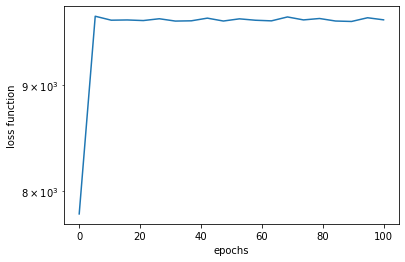

In [398]:
w = np.linspace(0, 100, 20)
loss_array = np.array(loss_list)
plt.axes(yscale = "log")
plt.plot(w, loss_array, label='Loss')
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.show()

### Batch Training